In [1]:
import numpy as np
import os
import sys
import neal
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import random as rd
import pickle

In [2]:
def calculate_Nspins(L):
    return np.prod(L)

def calculate_Npairs(L):
    return 2*np.prod(L)-L[0]-L[1]

def manhattan_distance(A,B):
    tmp = 0
    for i in range(len(A)):
        tmp += np.abs(A[i]-B[i])
    return tmp

In [3]:
def draw_ising_2d(x):
    spins = np.array(x[:Nspins])
    print("Spins = ", spins)
    print("Nspins up = ", np.count_nonzero(spins == 1))
    spins_plot = spins.reshape(L)
    pairs = np.array(x[Nspins:Nspins+Npairs])
    print("Pairs = ", pairs)
    print("N parallel pairs = ", np.count_nonzero(pairs == 1))
    X, Y = np.meshgrid(range(L[0]), range(L[1]))
    
    plt.figure(figsize=(3.5,3))
    fig = plt.pcolormesh(X, Y, spins_plot, cmap=plt.cm.binary)
    plt.colorbar(ticks=[-1, 1], format=mticker.FixedFormatter(['Down', 'Up']))
    plt.xticks([i for i in range(L[0])], [str(i) for i in range(L[0])])
    plt.yticks([i for i in range(L[1])], [str(i) for i in range(L[1])])
    for i in range(len(pair_hash_table)):
        if pairs[i] == 1:
            plt.plot([cartesian_coordinates[pair_hash_table[i][0]][0], cartesian_coordinates[pair_hash_table[i][1]][0]], [cartesian_coordinates[pair_hash_table[i][0]][1], cartesian_coordinates[pair_hash_table[i][1]][1]], '--', color='tab:orange')
        elif pairs[i] == -1:
            plt.plot([cartesian_coordinates[pair_hash_table[i][0]][0], cartesian_coordinates[pair_hash_table[i][1]][0]], [cartesian_coordinates[pair_hash_table[i][0]][1], cartesian_coordinates[pair_hash_table[i][1]][1]], '-', color='tab:blue')
        else:
            print("Non valid value for spin variable")
    orange_patch = mpatches.Patch(color='tab:orange', label='Parallel')
    blue_patch = mpatches.Patch(color='tab:blue', label='Antiparallel')
    plt.legend(handles=[orange_patch,blue_patch], bbox_to_anchor=(1.7, 0.15, 0.1, 0.5))
    plt.show()

In [4]:
L=np.array([2,2])

Nspins = calculate_Nspins(L)
Npairs = calculate_Npairs(L)

cartesian_coordinates = []
for j in range(L[0]):
    for i in range(L[1]):
        cartesian_coordinates.append([i,j])
        
pair_hash_table=[]
for i in range(len(cartesian_coordinates)):
    for j in range(i,len(cartesian_coordinates)):
        if manhattan_distance(cartesian_coordinates[i],cartesian_coordinates[j]) == 1:
            pair_hash_table.append([i,j])

In [5]:
# Parameters of scan
# Starting number of sweeps
ns = 1000
print("Number of sweeps = ", ns)

nsolutions = 100000
print("Number of solutions = ", nsolutions)

Number of sweeps =  1000
Number of solutions =  100000


In [6]:
folders = ['2_slacks_binary_encoding', '2_slacks_non_binary_encoding', '2_slack_redundant_binary_encoding']

Folder = 2_slacks_binary_encoding
Offset =  7.0
Starting to look for  100000  solutions

[0.11992 0.70839 0.17169]


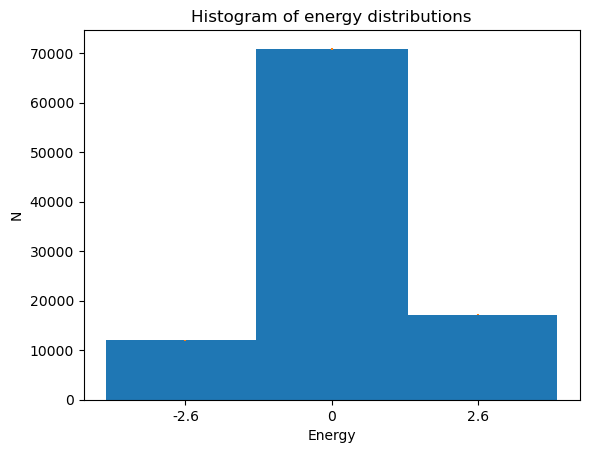

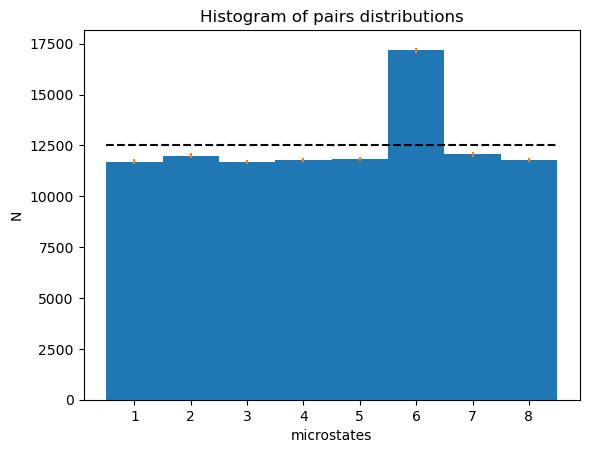

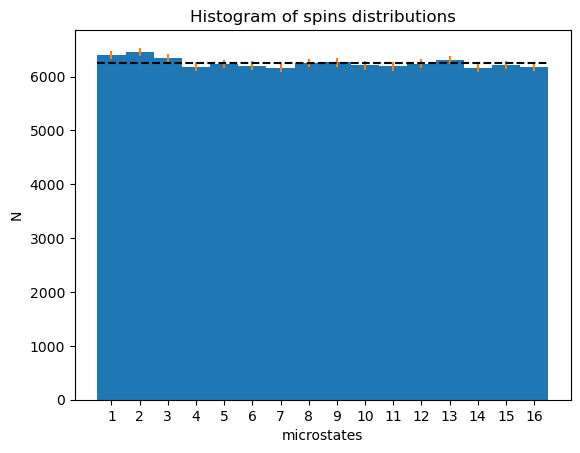

Folder = 2_slacks_non_binary_encoding
Offset =  3.0
Starting to look for  100000  solutions

[0.072   0.85552 0.07248]


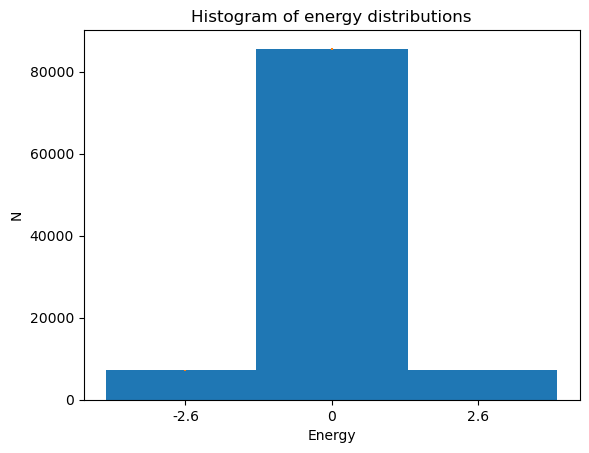

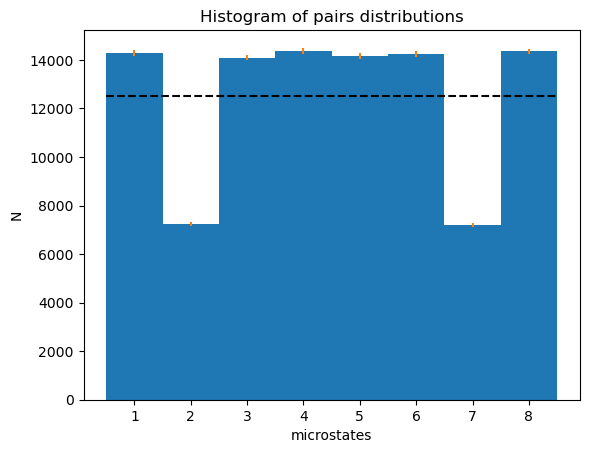

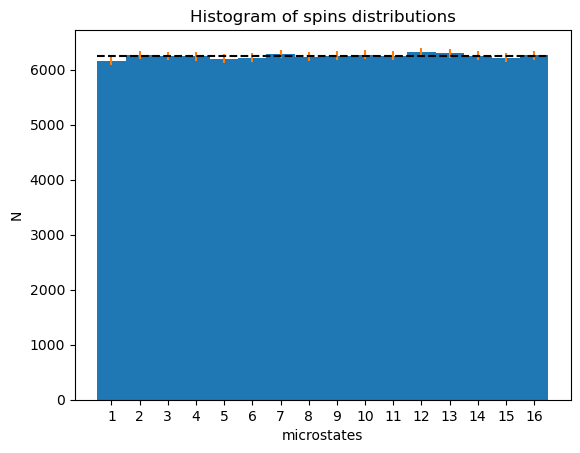

Folder = 2_slack_redundant_binary_encoding
Offset =  2.5
Starting to look for  100000  solutions

[0.33336 0.40109 0.26555]


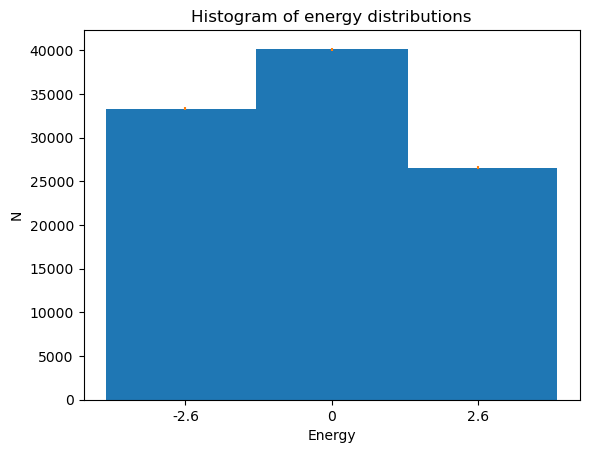

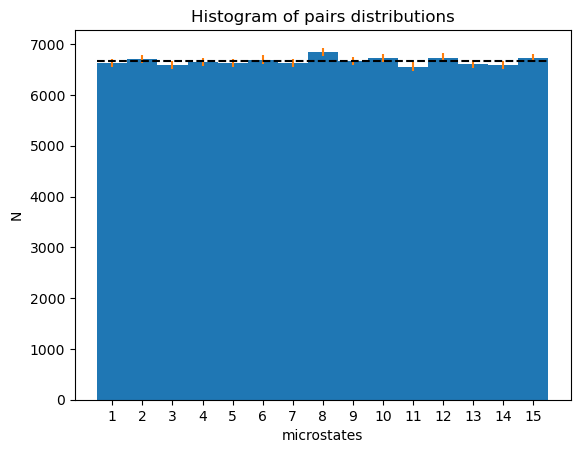

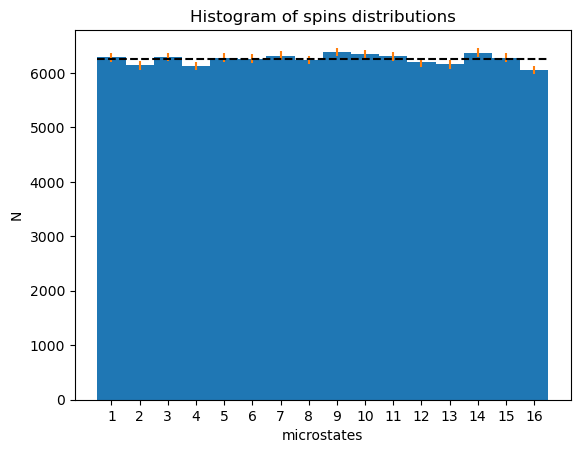

In [7]:
for folder in folders:
    print(f"Folder = {folder}")
    # Use Simulated annealing
    sampler = neal.SimulatedAnnealingSampler()
    # Load fields and offset energy
    # Fields and couplings
    h = np.loadtxt(f'{folder}/h.txt')
    J = np.loadtxt(f'{folder}/J.txt')

    Dwave_file = str([filename for filename in os.listdir(f'./{folder}') if filename.startswith("Dwave")][0])
    f = open(f'{folder}/{Dwave_file}', "r")
    Eoffset = float(f.read())
    f.close()
    print("Offset = ", Eoffset)

    seed_list = []
    for i in range(int(nsolutions*10)):
        seed_list.append(rd.randrange(1,1e7))

    seed_list = list(dict.fromkeys(seed_list))
    if len(set(seed_list)) != len(seed_list):
        print("Error, not unique seed list")

    print("Starting to look for ", nsolutions, " solutions\n")
    counter = 0
    configurations = []
    k = 0
    while counter < nsolutions:
        seed = seed_list[k]
        results = sampler.sample_ising(h,J,num_reads=1,num_sweeps=ns, seed=seed, beta=[0.05, 1])
        k += 1
        if np.abs(results.record[0][1]+Eoffset)<1e-6:
            counter += 1
            x = results.record[0][0]
            configurations.append(x)
         
    ######
    configurations_spins = []
    configurations_pairs = []
    energies = []
    for i in range(len(configurations)):
        configurations_spins.append(list(configurations[i][:Nspins]))
        configurations_pairs.append(list(configurations[i][Nspins:Nspins+Npairs]))
        energies.append(np.sum(configurations[i][Nspins:Nspins+Npairs]))
        
    #####
    ticks = [-2.6, 0, 2.6]

    plt.figure()
    counts, bins, fig = plt.hist(energies, bins=[-4.01, -1.35, 1.35, 4.01])
    print(counts/np.sum(counts))
    plt.errorbar(ticks, counts, yerr=np.sqrt(counts), fmt='none', color="tab:orange")
    plt.xticks(ticks, [str(t) for t in ticks])
    plt.xlabel("Energy")
    plt.ylabel("N")
    plt.title("Histogram of energy distributions")
    plt.show()

    set_configurations_pairs = []
    for conf in configurations_pairs:
        if conf not in set_configurations_pairs:
            set_configurations_pairs.append(list(conf))

    mapped_configurations_pairs = []
    for i in range(len(configurations_pairs)):
        mapped_configurations_pairs.append(set_configurations_pairs.index(configurations_pairs[i]))

    bins = [-0.5+i for i in range(max(mapped_configurations_pairs)+2)]
    ticks = [i for i in range(max(mapped_configurations_pairs)+1)]

    plt.figure()
    counts, bins, fig = plt.hist(mapped_configurations_pairs, bins=bins)
    plt.errorbar(ticks, counts, yerr=np.sqrt(counts), fmt='none', color="tab:orange")
    plt.plot([bins[0], bins[-1]], [np.sum(counts)/len(ticks), np.sum(counts)/len(ticks)], '--', color='k')

    plt.xticks(ticks, [str(t+1) for t in ticks])
    plt.xlabel("microstates")
    plt.ylabel("N")
    plt.title("Histogram of pairs distributions")
    plt.show()
    
    set_configurations_spins = []
    for conf in configurations_spins:
        if conf not in set_configurations_spins:
            set_configurations_spins.append(list(conf))

    mapped_configurations_spins = []
    for i in range(len(configurations_spins)):
        mapped_configurations_spins.append(set_configurations_spins.index(configurations_spins[i]))

    bins = [-0.5+i for i in range(max(mapped_configurations_spins)+2)]
    ticks = [i for i in range(max(mapped_configurations_spins)+1)]

    plt.figure()
    counts, bins, fig = plt.hist(mapped_configurations_spins, bins=bins)
    plt.errorbar(ticks, counts, yerr=np.sqrt(counts), fmt='none', color="tab:orange")
    plt.plot([bins[0], bins[-1]], [np.sum(counts)/len(ticks), np.sum(counts)/len(ticks)], '--', color='k')

    plt.xticks(ticks, [str(t+1) for t in ticks])
    plt.xlabel("microstates")
    plt.ylabel("N")
    plt.title("Histogram of spins distributions")
    plt.show()